In [19]:
from enum import Enum
import random 
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt

In [350]:

class CellType(Enum):
    PROLIFERATING = [28/255, 241/255, 93/255]
    COMPLEX = [26/255, 69/255, 245/255]
    DEAD = [245/255, 72/255, 27/255]
    NECROTIC = [130/255, 130/255, 130/255]
    
    
    
class Cell:
    
    def __init__(self, x, y, cellType, nNeighbors):
        self.x = x
        self.y = y
        self.cellType = cellType
        #Tiempo de muerte según el artículo
        self.life = 20 + nNeighbors + poisson.rvs(mu = 1, size = 1)
    
    def __eq__(self, other):
        self.x == other.x and self.y == other.y
        
    def dayInTheLife(self):
        self.life = self.life - 1
        #Si ha pasado su tiempo de vida se vuelve necrotica
        if(self.life == 0):
            self.cellType = CellType.NECROTIC
    

class Tissue:
    
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.occupiedPositions = np.zeros((self.height, self.width))
        self.necroticPositions = np.zeros((self.height, self.width))
        self.initializeECM()
        self.cells = []
        self.colorNecrotic = [176/255, 176/255, 176/255]
        #Tasa de consumo de la matriz extracelular
        self.ec = 0.1
        self.et = 0.05
        #Otros parámetros
        self.rProlif = 0.85
        self.rBinding = 0.1
        self.rEscape = 0.5
        self.rLysis = 0.35
        self.rDecay = 0.35
        self.K = 1000
        
        
    def initializeECM(self):
        self.extraCellularMatrix = np.zeros((self.height, self.width))
        for i in range(0, self.height):
            for j in range(0,self.width):
                #La ECM inicia con valores de [0.8,1.2]
                self.extraCellularMatrix[i,j] = 0.8 + random.random()*(1.2 - 0.8)
    
    
    def countNeighbors(self, x, y):        
        sumNeighbors = 0
        for i in range(-1,2):
            for j in range(-1,2):
                if(i != 0 or j!= 0):
                    sumNeighbors = sumNeighbors + self.occupiedPositions[(y + j)%self.width, (x + i)%self.height]
        return sumNeighbors
    
    def getPositionsToInfest(self, x, y):
        positions = [];
        for i in range(-1,2):
            for j in range(-1, 2):
                if(i != 0 or j!= 0):
                    row = (y + i)%self.width
                    col = (x + j)%self.height
                    if(self.occupiedPositions[row, col]  == 0 and self.necroticPositions[row, col] == 0 and self.extraCellularMatrix[row, col] < self.et):
                        positions.append([row, col])
        
        return positions
    
    def updateECM(self):
        for i in range(0,self.height):
            for j in range(0,self.width):
                deltaECM = -self.ec*self.countNeighbors(j, i)*self.extraCellularMatrix[i,j]
                self.extraCellularMatrix[i,j] = self.extraCellularMatrix[i,j] + deltaECM
        
    def updateCells(self):
        cellsToDelete = []
        indsList = list(range(0,len(self.cells)))
        random.shuffle(indsList)
        for i in indsList:
            cell = self.cells[i]
            r = random.random()
            #Proliferadoras
            if(cell.cellType == CellType.PROLIFERATING):
                if(r <= self.rProlifPrime):
                    normalCells = self.getPositionsToInfest(cell.x, cell.y)
                    #print(len(normalCells))
                    if(len(normalCells)>0):
                        normalCell = random.choice(normalCells)
                        self.addProliferatingCell(normalCell[1], normalCell[0])
                else:
                    if(r <= 1 - self.rBinding):
                        self.cells[i].cellType = CellType.COMPLEX
            #Complejas
            elif(cell.cellType == CellType.COMPLEX):
                if(r <= self.rEscape):
                    self.cells[i].cellType = CellType.PROLIFERATING
                elif(r >= 1 - self.rLysis):
                    self.cells[i].cellType = CellType.DEAD
                    
            elif(cell.cellType == CellType.DEAD):
                if(r < self.rDecay):
                    cellsToDelete.append(cell)
                    
            self.cells[i].dayInTheLife()
            if(self.cells[i].cellType == CellType.NECROTIC):
                self.necroticPositions[cell.y, cell.x] = 1
                cellsToDelete.append(cell)
        
        for i in range(0,len(cellsToDelete)):
            if(cellsToDelete[i] in self.cells):
                self.removeCell(cellsToDelete[i])
    
    
    def getCellCounts(self):
        
        proliferatingCells = 0
        complexCells = 0
        for i in range(0,len(self.cells)):
            cell = self.cells[i]
            if(cell.cellType == CellType.PROLIFERATING):
                proliferatingCells = proliferatingCells + 1
            elif(cell.cellType == CellType.COMPLEX):
                complexCells = complexCells + 1
                
        return [proliferatingCells, complexCells, len(self.cells)]
    
    def plotEvolution(self):
        n = np.size(self.cellCountSeries, 0)
        plt.figure(figsize = (10,7))
        plt.plot(self.cellCountSeries[:,0], color = CellType.PROLIFERATING.value, label = "Proliferadora", linewidth = 2)
        plt.plot(self.cellCountSeries[:,1], color = CellType.COMPLEX.value, label = "Compleja", linewidth = 2)
        plt.plot(self.cellCountSeries[:, 2], color = "#ff9a26", label = "Células", linewidth = 2)
        plt.xlabel("Paso")
        plt.ylabel("N.Células")
        plt.legend()
        
    
    
    
    def evolveTissue(self, nSteps):
        self.cellCountSeries = np.zeros((nSteps+1, 3)) 
        counts = self.getCellCounts()
        self.cellCountSeries[0,:] = counts
        for i in range(1, nSteps+1):
            self.rProlifPrime = self.rProlif*(1 - counts[0]/self.K)
            self.updateECM()
            self.updateCells()
            counts = self.getCellCounts()
            self.cellCountSeries[i,:] = counts
    
    def addProliferatingCell(self, x, y):
        nNeighbors = self.countNeighbors(x,y)
        self.cells.append(Cell(x,y,CellType.PROLIFERATING, nNeighbors))
        self.occupiedPositions[y,x] = 1
        
        
    def getPicture(self):
        picture = np.zeros((self.height, self.width, 3))
        for i in range(0, len(self.cells)):
            picture[self.cells[i].y, self.cells[i].x,:] = self.cells[i].cellType.value
            
        for i in range(0, self.height):
            for j in range(0, self.width):
                if(self.necroticPositions[i,j] == 1):
                    picture[i,j,:] = self.colorNecrotic
        
        return picture
            
                          
    def removeCell(self, cell):
        self.cells.remove(cell)
        self.occupiedPositions[cell.y, cell.x] = 0
                          
        
    
    #Hagamos 
        
    
    
        
        
    

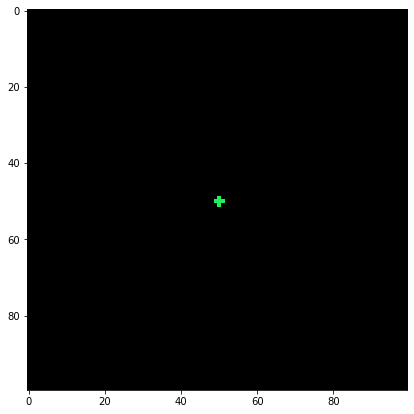

In [351]:
width = 100
height = 100

centerX = int(width/2)
centerY = int(width/2)


tissue = Tissue(width, height)


#Inicializamos el tejido
tissue.addProliferatingCell(centerX, centerY)
tissue.addProliferatingCell(centerX + 1,centerY)
tissue.addProliferatingCell(centerX - 1, centerY)
tissue.addProliferatingCell(centerX, centerY + 1)
tissue.addProliferatingCell(centerX, centerY - 1)


plt.figure(figsize = (7,7))
plt.imshow(tissue.getPicture())

In [352]:
tissue.evolveTissue(500)

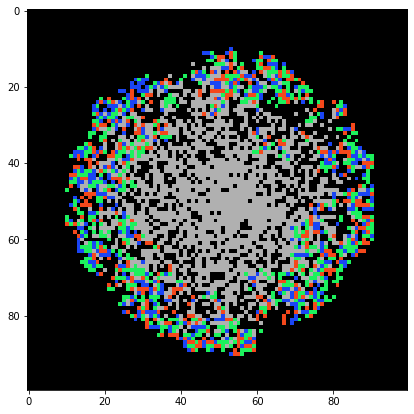

In [345]:
plt.figure(figsize = (7,7))
plt.imshow(tissue.getPicture())

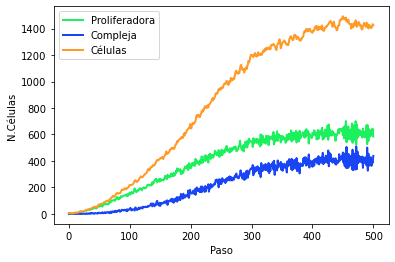

In [346]:
tissue.plotEvolution()